В этой части проекта написаны несколько SQL-запросов в Jupyter Notebook.

**Данные**
<br>Необходимые данные находятся в таблицах схемы `stackoverflow`.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine 

## Запросы

In [2]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

In [4]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine) 

In [5]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


### SQL запросы

# Запрос 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

In [6]:
# запрос
query = '''
SELECT DATE_TRUNC('month', creation_date)::date AS month_date,
       SUM(views_count) AS total_views
FROM stackoverflow.posts
WHERE EXTRACT(YEAR FROM creation_date) = 2008
GROUP BY month_date
ORDER BY total_views DESC
'''

# выполнение запроса
sample_df = pd.read_sql_query(query, con=engine) 

In [7]:
sample_df

,month_date,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


***Данные за разные месяцы различаются. Это может быть связано с тем, что сайт был открыт в конце июля 2008 года, и далее количество просмотров соответсвенно росло. Снижение просмотров с октября может быть связано с тем, что количество уникальных вопросов и ответов соответсвенно уменьшалось ввиду решения подобных задач ранее.***

# Запрос 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

In [8]:
# запрос
query = '''
SELECT u.display_name,
       COUNT(DISTINCT u.id)
FROM stackoverflow.posts p
     JOIN stackoverflow.post_types pt 
     ON p.post_type_id = pt.id
     JOIN stackoverflow.users u 
     ON p.user_id = u.id
WHERE pt.type = 'Answer'
      AND p.creation_date < u.creation_date + INTERVAL '1 months'
GROUP BY display_name
HAVING COUNT(p.id) > 100
ORDER BY display_name
'''

# выполнение запроса
sample_df = pd.read_sql_query(query, con=engine) 

In [9]:
sample_df

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
...,...,...
71,leppie,1
72,lomaxx,1
73,mattlant,1
74,paxdiablo,1


In [10]:
sample_df_more = sample_df[sample_df['count'] > 1].sort_values(by='count', ascending=False)
sample_df_more

,display_name,count
10,Chris,29
43,Matt,29
14,Dan,21
62,Tom,19
33,Josh,16
40,Mark,16
48,Nick,16
7,Brian,15
54,Rob,15
21,Greg,12


In [11]:
print(f'На {sample_df_more.shape[0]} никнеймов приходится {sample_df_more["count"].sum()} уникальных id.')

На 19 никнеймов приходится 254 уникальных id.


***В данных наблюдается определенная аномалия: количество уникальных id превышает количество никнеймов. Это говорит о том, что есть пользователи с одинаковыми именами (никнеймами).***

# Запрос 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

In [12]:
# запрос
query = '''
SELECT DATE_TRUNC('month', creation_date)::date AS month,
       COUNT(id)
FROM stackoverflow.posts
WHERE user_id IN (SELECT DISTINCT u.id FROM stackoverflow.users AS u 
                         JOIN stackoverflow.posts AS p
                         ON u.id = p.user_id
                         WHERE EXTRACT(MONTH FROM u.creation_date) = 9
                         AND EXTRACT(MONTH FROM p.creation_date) = 12)
GROUP BY month
ORDER BY month DESC
'''

# выполнение запроса
sample_df = pd.read_sql_query(query, con=engine) 

In [13]:
sample_df

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


***В данных существует одна аномалия: 32 поста за август от пользователей, которые зарегестрировались только в сентябре. Возможно это связано с технической ошибкой.***

# Запрос 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

In [14]:
# запрос
query = '''
SELECT user_id,
       creation_date,
       views_count,
       SUM(views_count) OVER(PARTITION BY user_id ORDER BY creation_date)
FROM stackoverflow.posts
ORDER BY user_id, creation_date
'''

# выполнение запроса
sample_df = pd.read_sql_query(query, con=engine)

In [15]:
sample_df

,user_id,creation_date,views_count,sum
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Запрос 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

In [16]:
# запрос
query = '''
WITH df AS
(SELECT user_id,
       DATE_TRUNC('day', creation_date)::date,
       COUNT(id)
FROM stackoverflow.posts
WHERE user_id IN
  (SELECT user_id
  FROM stackoverflow.posts
  WHERE DATE_TRUNC('month', creation_date)::date = '2008-08-01'
  GROUP BY user_id
  HAVING COUNT(id) > 120)
GROUP BY user_id, DATE_TRUNC('day', creation_date)::date)


SELECT d.user_id,
       AVG(d.count)
FROM df d
WHERE DATE_TRUNC('month', d.date_trunc)::date = '2008-08-01'
GROUP BY 1
ORDER BY 2
'''

# выполнение запроса
sample_df = pd.read_sql_query(query, con=engine)

In [17]:
sample_df

,user_id,avg
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Запрос 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

In [18]:
# запрос
query = '''
WITH count_days AS
(SELECT user_id,
        COUNT(DISTINCT DATE_TRUNC('day', creation_date)::date)
 FROM stackoverflow.posts
 WHERE DATE_TRUNC('day', creation_date)::date BETWEEN '2008-12-01' AND '2008-12-07'
 GROUP BY user_id
)

SELECT ROUND(AVG(count))::int
FROM count_days
'''

# выполнение запроса
sample_df = pd.read_sql_query(query, con=engine)

In [19]:
sample_df

,round
0,2


Проанализируйте итоговую таблицу — какие выводы можно сделать?

***Из представленных результатов можно сделать вывод, что пользователи взаимодействовали с платформой в среднем 2 дня.***

# Запрос 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  

In [20]:
# запрос
query = '''
WITH month_before AS 
(SELECT user_id,
        creation_date,
        LAG(creation_date, 2) OVER(PARTITION BY user_id ORDER BY creation_date)::date AS prev_date
FROM stackoverflow.posts
ORDER BY user_id, creation_date)


SELECT user_id,
       creation_date,
       CASE
           WHEN EXTRACT(MONTH FROM prev_date) = 7 THEN 'July'
           WHEN EXTRACT(MONTH FROM prev_date) = 8 THEN 'August'
           WHEN EXTRACT(MONTH FROM prev_date) = 9 THEN 'September'
           WHEN EXTRACT(MONTH FROM prev_date) = 10 THEN 'October'
           WHEN EXTRACT(MONTH FROM prev_date) = 11 THEN 'November'
           WHEN EXTRACT(MONTH FROM prev_date) = 12 THEN 'December'
       END
FROM month_before
ORDER BY user_id, creation_date
'''

# выполнение запроса
sample_df = pd.read_sql_query(query, con=engine)

In [21]:
sample_df

,user_id,creation_date,case
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


# Запрос 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

In [22]:
# запрос
query = '''
WITH cohort AS
(SELECT DISTINCT user_id,
        MIN(DATE_TRUNC('month', creation_date)::date) 
        OVER(PARTITION BY user_id ORDER BY DATE_TRUNC('month', creation_date)) AS cohort_dt
 FROM stackoverflow.posts
),

profile AS
(SELECT *,
        COUNT(user_id) OVER(PARTITION BY cohort_dt) AS cohort_users_cnt
 FROM cohort
),

sessions AS
(SELECT user_id,
        DATE_TRUNC('month', creation_date) AS session_date
FROM stackoverflow.posts
GROUP BY user_id, 
         session_date)

SELECT p.cohort_dt,
       s.session_date,
       COUNT(p.user_id) AS users_cnt,
       p.cohort_users_cnt,
       ROUND(COUNT(p.user_id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM profile p 
     JOIN sessions s 
     ON p.user_id=s.user_id
GROUP BY p.cohort_dt,
       s.session_date,
       p.cohort_users_cnt
'''

# выполнение запроса
sample_df = pd.read_sql_query(query, con=engine)

In [23]:
sample_df

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


Построим тепловую карту Retention Rate и выявим аномалии или другие необычные явления.

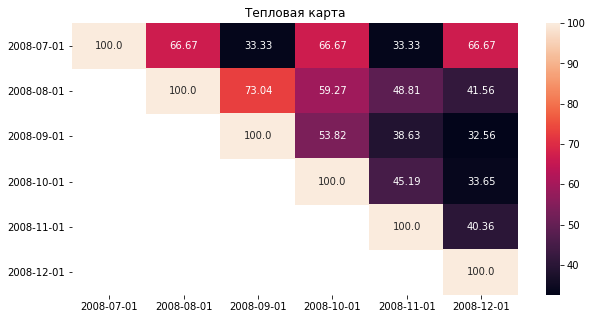

In [24]:
# создаём сводную таблицу с результатами
retention = sample_df.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]

# строим хитмэп
plt.figure(figsize=(10, 5)) # задаём размер графика
sns.heatmap(retention, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show() 

***Аномалии и необычные явления (гипотезы):***
1. Активности первой когорты цикличны;
2. Активности второй и последующих когорт  убывают с большим отрывом с каждым месяцом.

Вероятно, это связано с тем, что вопросы были решены ранее, тем самым активности пользоваталей уменьшаются с каждым месяцем.

# Запрос 9

На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

In [25]:
# запрос
query = '''
WITH posts_count AS
(SELECT EXTRACT(MONTH FROM creation_date) AS creation_month,
       COUNT(id) AS posts_count
FROM stackoverflow.posts
WHERE creation_date BETWEEN '2008-09-01' AND '2008-12-31'
GROUP BY creation_month)

SELECT *,
       ROUND((posts_count::numeric / LAG(posts_count) OVER(ORDER BY creation_month) -1) *100, 2) AS percentage
FROM posts_count
'''

# выполнение запроса
sample_df = pd.read_sql_query(query, con=engine)

In [26]:
sample_df

,creation_month,posts_count,percentage
0,9.0,70371,NaN
1,10.0,63102,-10.33
2,11.0,46975,-25.56
3,12.0,44592,-5.07


Построим круговую диаграмму с количеством постов по месяцам.

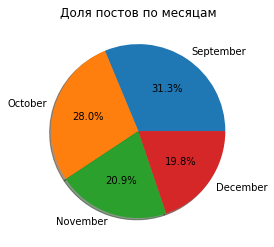

In [27]:
labels = ['September', 'October', 'November', 'December']
plt.pie(sample_df['posts_count'], labels=labels, autopct='%1.1f%%', shadow=True);
plt.title('Доля постов по месяцам');

# Запрос 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

In [28]:
# запрос
query = '''
WITH id_max_user AS
(SELECT user_id,
       COUNT(id) AS count
FROM stackoverflow.posts
GROUP BY user_id
ORDER BY count DESC
LIMIT 1)

SELECT EXTRACT(WEEK FROM creation_date) AS week_creation,
       MAX(creation_date) as creation_date
FROM stackoverflow.posts
WHERE user_id IN (SELECT user_id FROM id_max_user)
      AND DATE_TRUNC('month', creation_date)::date = '2008-10-01'
GROUP BY week_creation
'''

# выполнение запроса
sample_df = pd.read_sql_query(query, con=engine)

In [29]:
sample_df

,week_creation,creation_date
0,40.0,2008-10-05 09:00:58
1,41.0,2008-10-12 21:22:23
2,42.0,2008-10-19 06:49:30
3,43.0,2008-10-26 21:44:36
4,44.0,2008-10-31 22:16:01


## Общий вывод

В рамках данной части проекта было написано несколько SQL-запросов в Jupyter Notebook с помощью SQLAlchemy. 
Были выполнены следующие основыне этапы:
- Подключение к базе данных;
- Написание 10 основных sql запросов.

***Также в ходе выполнения запросов были выявлены определенные аномалии, в частности:***
- Данные за разные месяцы различаются по общей суммы просмотров постов за каждый месяц 2008 года. Это может быть связано с тем, что сайт был открыт в конце июля 2008 года, и далее количество просмотров соответсвенно росло. Снижение просмотров с октября может быть связано с тем, что количество уникальных вопросов и ответов соответсвенно уменьшалось ввиду решения подобных задач ранее;
- В данных наблюдается определенная аномалия: количество уникальных id превышает количество никнеймов. Это говорит о том, что есть пользователи с одинаковыми именами (никнеймами);
- В данных существует определенная аномалия: 32 поста за август от пользователей, которые зарегестрировались только в сентябре. Возможно это связано с технической ошибкой;
- Из представленных результатов можно сделать вывод, что пользователи взаимодействовали с платформой в среднем 2 дня;
- 1. Активности первой когорты цикличны;
  2. Активности второй и последующих когорт  убывают с большим отрывом с каждым месяцом.
<br>Вероятно, это связано с тем, что вопросы были решены ранее, тем самым активности пользоваталей уменьшаются с каждым месяцем.